In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/'Colab Notebooks'/'yai_9기 겨울방학'/ToyProject

/content/drive/MyDrive/Colab Notebooks/yai_9기 겨울방학/ToyProject


In [ ]:
!pip upgrade ignite

ERROR: unknown command "upgrade"


In [98]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import random_split

import matplotlib as mpl
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [ ]:
diamond_df = pd.read_csv('./data/images/total.csv')
diamond_df_drop = diamond_df.drop_duplicates(['Id'], keep = 'last')
names = os.listdir('./data/images')
names = list(map(lambda s: s.rstrip('.jpg'),names))
print("csv 중복제거전 중복제거후 : ",len(diamond_df), len(diamond_df_drop))
print("이미지 개수",len(os.listdir('./data/images')))
print("이미지 파일명 \n",names)

idxes = []
for i in range(len(diamond_df_drop)):
    if diamond_df_drop['Id'].iloc[i] not in names:
        idxes.append(diamond_df_drop.index[i])
print("제거돼야할 index들 : ", idxes)
diamond_df_drop.drop(idxes)
# idxes = diamond_df_drop[diamond_df_drop['Id'] not in names].index
# diamond_df_drop = diamond_df_drop(idxes)
# print("이미지 파일 없는 것 제거 후",len(diamond_df_drop))


csv 중복제거전 중복제거후 :  5064 4801
이미지 개수 4728
이미지 파일명 
 ['1795910', '1795914', '1795940', '1795943', '1795945', '1795947', '1795950', '1795979', '1795999', '1796000', '1796002', '1796003', '1796006', '1796014', '1796020', '1796021', '1796026', '1796029', '1796036', '1796043', '1796044', '1796049', '1796057', '1796060', '1796068', '1796072', '1796078', '1796080', '1796088', '1796090', '1796091', '1796093', '1796183', '1796186', '1796187', '1796188', '1796191', '1796194', '1796196', '1796197', '1796198', '1796200', '1796202', '1796205', '1796210', '1796211', '1796215', '1796217', '1796219', '1796221', '1796222', '1796223', '1796226', '1796228', '1796230', '1796233', '1796235', '1796236', '1796237', '1796239', '1796244', '1796311', '1796524', '1796662', '1796686', '1796723', '1796728', '1796759', '1796801', '1796825', '1796829', '1797109', '1797157', '1797169', '1797184', '1797189', '1797203', '1797205', '1797211', '1797212', '1797213', '1797216', '1797219', '1797227', '1797235', '1797240', '1

,Id,Shape,Weight,Clarity,Colour,Cut,Polish,Symmetry,Fluorescence,Length,Width,Depth,Price
0,1638147,CUSHION,0.55,SI2,E,EX,EX,VG,N,5.05,4.35,2.94,1378.65
1,1630155,CUSHION,0.50,VVS1,FANCY,EX,EX,VG,F,4.60,4.31,2.92,1379.74
2,1612606,CUSHION,0.51,VS2,H,EX,EX,VG,N,4.71,4.35,2.94,1380.19
3,1638140,CUSHION,0.50,VS2,H,EX,EX,VG,N,4.91,4.26,2.88,1380.61
4,1536093,CUSHION,0.53,SI1,D,EX,VG,VG,N,4.70,4.46,3.01,1383.13
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5057,1665044,ROUND,0.90,VS1,Q-R,EX,EX,EX,N,6.10,6.14,3.86,2452.76
5060,1751206,ROUND,0.50,SI1,E,EX,EX,EX,N,5.00,5.04,3.18,2453.10
5061,1773024,ROUND,0.50,SI1,E,EX,EX,EX,N,5.03,5.06,3.16,2453.10
5062,1774887,ROUND,0.52,SI1,H,EX,EX,EX,N,5.11,5.13,3.20,2453.41


In [ ]:
names = os.listdir('./data/images')
sizes = []
imageSize = []
for name in names:
    if name == 'total.csv':
        continue
    image = Image.open('./data/images/' + name)
    image = np.array(image)
    sizes.append(image.shape)
    if image.shape == (508, 646, 3):
        imageSize.append(name)

sizes = set(sizes)
print(sizes)


{(300, 300, 3)}


In [103]:
class DiamondDataset(Dataset):
    def __init__(self, path, transform, train = True):
        self.transform = transform
        self.path = path
        diamond_df = pd.read_csv(path + '/total.csv')
        diamond_df = diamond_df.drop_duplicates(['Id'], keep = 'last')

        names = os.listdir(path)
        names = list(map(lambda s: s.rstrip('.jpg'),names))

        idxes = []
        for i in range(len(diamond_df)):
            if diamond_df['Id'].iloc[i] not in names:
                idxes.append(diamond_df.index[i])
        
        diamond_df = diamond_df.drop(idxes)
        self.diamond_df = diamond_df
        
        
    def __len__(self):
        return len(self.diamond_df)

    def __getitem__(self, idx):
        price = self.diamond_df['Price'].iloc[idx]
        name =  self.diamond_df['Id'].iloc[idx]
        image = Image.open(self.path +'/' + name + '.jpg')

        if self.transform:
            image = self.transform(image)
        return torch.tensor(image, dtype = torch.float), torch.tensor(price, dtype = torch.float)

In [ ]:
!pwd

/content/drive/MyDrive/Colab Notebooks/yai_9기 겨울방학/ToyProject


In [104]:
dataset = DiamondDataset(path = './data/images',
                         transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.5,0.5,0.5),
                                                          (0.5,0.5,0.5))                          
                                      ]))
image, price = next(iter(dataset))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


tensor(1378.6500)


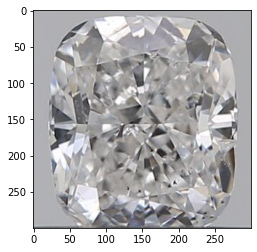

In [101]:
plt.imshow(transforms.ToPILImage()(image*0.5+0.5)) # Normalize 처리때문에 복구
print(price)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3

torch.Size([16, 3, 300, 300])


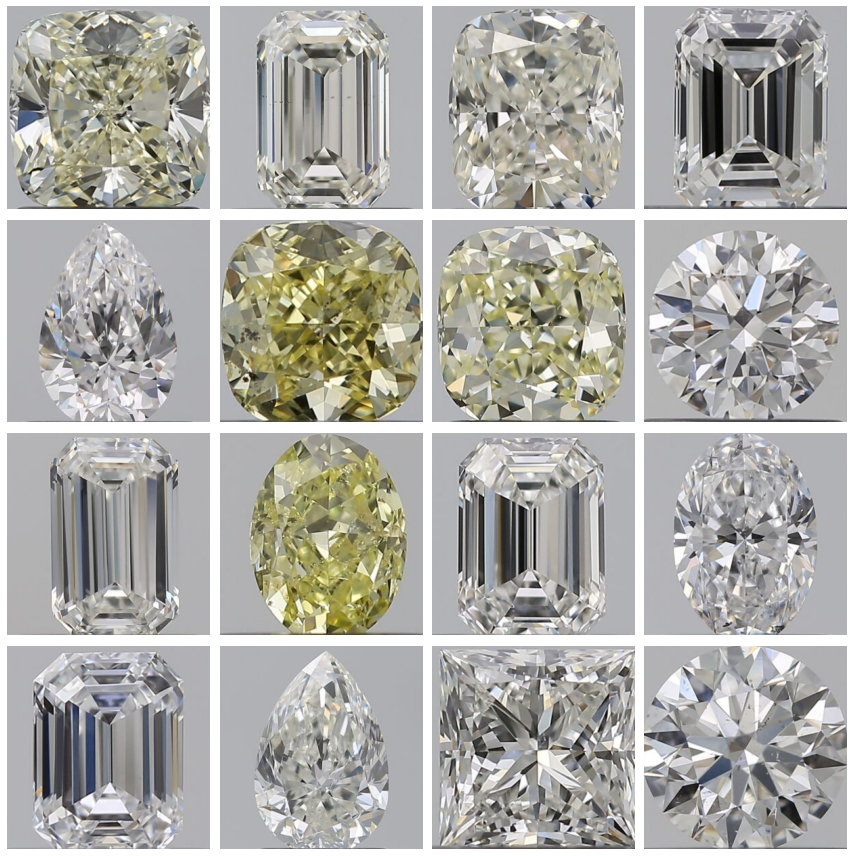

In [122]:
dataloader= DataLoader(dataset=dataset,
                       batch_size=16,
                       shuffle=True,
                       num_workers=4,
                       )
images, labels = next(iter(dataloader))
print(images.shape)
plt.figure(figsize=(12,12))

for n, (image, label) in enumerate(zip(images, labels), start=1):
    plt.subplot(4,4,n)
    plt.imshow(transforms.ToPILImage()(image*0.5+0.5))  # Normalize 처리때문에 복구
    plt.axis('off')
plt.tight_layout()
plt.show()

In [112]:
# 모델
resnet18 = torchvision.models.resnet18(pretrained=False)
resnet18.conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
resnet18.fc = nn.Sequential(
    nn.Linear(in_features = 512, out_features = 120, bias = True),
    nn.ReLU(),
    nn.Linear(in_features = 120, out_features = 1, bias = True),
    nn.ReLU()    
)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18.to(device)

epoch = 30
LEARNING_RATE = 0.0001
batch_size = 64

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=LEARNING_RATE)

In [118]:
dataset = DiamondDataset(path = './data/images',
                transform = transforms.Compose([
                            transforms.Resize((300,300)),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5,0.5,0.5),
                                                 (0.5,0.5,0.5))                          
                            ]))
length = len(dataset)
train_set, test_set = random_split(dataset, [int(length*0.8),length - int(length*0.8)])
train_loader= DataLoader(dataset=train_set,
                       batch_size=batch_size,
                       shuffle=True,
                       num_workers=1,
                       )
test_loader = DataLoader(dataset = test_set,
                         batch_size = batch_size,
                         shuffle = True,
                         num_workers = 1)

In [109]:
def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [113]:
for epoch in range(epoch):
    running_loss = 0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        pred = resnet18(images)
        loss = criterion(pred, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss
    avg_loss = running_loss/len(train_loader)
    print(f'[Epoch : {epoch}] average loss : {avg_loss}')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([64])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[Epoch : 0] average loss : 25174094.0


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([52])) that is different to the input size (torch.Size([52, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 1] average loss : 25074192.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 2] average loss : 24939258.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 3] average loss : 24719202.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 4] average loss : 24581476.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 5] average loss : 24231812.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 6] average loss : 23932244.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 7] average loss : 23609506.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 8] average loss : 23260538.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 9] average loss : 22885496.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 10] average loss : 22494344.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 11] average loss : 22089456.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 12] average loss : 21704602.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 13] average loss : 21485230.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 14] average loss : 20983370.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 15] average loss : 20656094.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 16] average loss : 20401590.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 17] average loss : 20103584.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 18] average loss : 19980750.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 19] average loss : 19944648.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 20] average loss : 19557676.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 21] average loss : 19681268.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 22] average loss : 19368086.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 23] average loss : 19386912.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 24] average loss : 19392230.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 25] average loss : 19211466.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 26] average loss : 19513082.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 27] average loss : 19185044.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 28] average loss : 19172738.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


[Epoch : 29] average loss : 19164476.0


In [127]:
resnet18.eval()
criterion = nn.MSELoss().to(device)
ss_tot = 0
ss_res = 0
with torch.no_grad():
    for images, prices in test_loader:
        images =images.to(device)
        prices = prices.to(device)
        prediction = resnet18(images).to(device)
        prices_mean = torch.mean(prices)
        ss_tot += torch.sum((prices - prices_mean) ** 2)
        ss_res = torch.sum((prices - prediction) ** 2)
    
    accuracy = 1 - ss_tot/ss_res        
    print(f"Accuracy: {accuracy*100:.2f}%")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Accuracy: 83.88%
